# Проект: "Разработка системы рекомендаций банковских продуктов"
## Ноутбук для EDA и обучения моделей
***

## Содержание
* [Инициализация](#step_0)
* [Развертывание MLflow](#step_1)
* [Описание исходных данных](#step_2)
* [Анализ данных (EDA)](#step_3)
* [Функции для расчета MAP@k](#step_4)
* [Расчет MAP@k на основе популярности продуктов (бейзлайн)](#step_5)
* [Базовая модель](#step_6)
* [Генерация признаков](#step_7)
* [Отбор признаков](#step_8)
* [Подбор гиперпараметров](#step_9)

## Инициализация <a id="step_0"></a>

In [1]:
# Убедимся, что работаем в нужном окружении
import sys

print(sys.executable)

c:\Users\Kirill_Nosov\_Repos\.venv\Scripts\python.exe


In [2]:
# Отключаем предупреждения
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning, FutureWarning, UserWarning))
#warnings.filterwarnings("ignore")

In [3]:
# Импортируем необходимые библиотеки

import os
import gc
from dotenv import load_dotenv

import boto3
from botocore.exceptions import ClientError

import numpy as np
import pandas as pd
pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_theme(style="whitegrid")

import joblib

from catboost import CatBoostClassifier, Pool
from category_encoders import CatBoostEncoder

from tqdm import tqdm
import datetime 
import time

import mlflow
from mlflow.utils.mlflow_tags import MLFLOW_PARENT_RUN_ID

import sklearn.preprocessing
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from category_encoders import CatBoostEncoder

#from autofeat import AutoFeatRegressor

#from mlxtend.feature_selection import SequentialFeatureSelector as SFS
#from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

#import optuna
#from optuna.integration.mlflow import MLflowCallback

In [4]:
# Инциализируем генератор случайных чисел
RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)

## Развертывание MLflow <a id="step_0"></a>

Для запуска MLflow нужно в терминале перейти в папку `/mlflow_server` и выполнить команду 

```sh run_mlflow_server.sh```

После этого устанавливаем параметры MLflow Tracking Server и MLflow Model Registry и задаем имя эксперимента с помощью кода ниже (у нас будет один эксперимент на все этапы, которым будут соответствовать разные запуски)

In [10]:
# Загружаем переменные окружения для S3-хранилища
load_dotenv()
os.environ["S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["S3_BUCKET_NAME"] = os.getenv("S3_BUCKET_NAME") 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

# Устанавливаем параметры MLflow
TRACKING_SERVER_HOST = '127.0.0.1' 
TRACKING_SERVER_PORT = 5000

tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
registry_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"

mlflow.set_tracking_uri(tracking_uri)
mlflow.set_registry_uri(registry_uri) 

EXPERIMENT_NAME = 'mle-final-project'

## Описание исходных данных <a id="step_1"></a>

Файл [train_ver2.csv](https://disk.yandex.com/d/Io0siOESo2RAaA) содержит информацию о поведении 
клиентов банка за 1.5 года. 
Данные начинаются с 28.01.2015 и включают ежемесячные записи о продуктах, которые были у клиента, например, «кредитная карта», «сберегательный счет» и т.д. Необходимо предсказать, какие дополнительные продукты купит клиент в последнем месяце, оканчивающемся 28.06.2016, в дополнение к тому, что было у него 28.05.2016. 
Эти продукты представляют собой столбцы с именами ind_(xyz)_ult1, которые идут с 25-ой по 48-ю колонку в обучающих данных.

Список полей:
- fecha_dato - колонка для разделения таблицы,
- ncodpers - идентификатор пользователя,
- ind_empleado - статус занятости:
    - A — трудоустроен,
    - B — безработный (раньше работал),
    - F — иждивенец,
    - N — безработный,
    - P — пассивный (статус не определён),
- pais_residencia - страна проживания,
- sexo - пол, H - мужской, V - женский,
- age - возраст,
- fecha_alta - дата, когда клиент впервые заключил договор в банке,
- ind_nuevo - 1, если клиент зарегистрировался в течение последних 6 мес.,
- antiguedad - стаж клиента (в мес.),
- indrel:
    - 1 — основной клиент (т.е. основной владелец продукта - first/primary),
    - 99 — основной клиент в течение месяца, но не в последний день месяца,
- ult_fec_cli_1t - последняя дата, когда клиент был основным,
- indrel_1mes - тип клиента по отношению к продукту в начале месяца:
    - 1 — основной,
    - 2 — совладелец,
    - P — потенциальный,
    - 3 — бывший основной,
    - 4 — бывший совладелец,
- tiprel_1mes - тип клиента по отношению к банку в начале месяца:
    - A — активный,
    - I — неактивный,
    - P — бывший,
    - R — потенциальный,
- indresi - признак совпадения страны проживания клиента со страной банка, S - совпадает, N - не совпадает,
- indext - признак не совпадения страны рождения клиента со страной банка, S - не совпадает, N - совпадает,
- conyuemp - 1, если клиент является супругом(ой) работника банка,
- canal_entrada - канал, через который был привлечен клиент,
- indfall - признак актуальности счёта (англ. Deceased index, N/S),
- tipodom - тип адреса, 1 — основной адрес,
- cod_prov - код провинции (адреса клиента),
- nomprov - название провинции,
- ind_actividad_cliente - признак активности пользователя (1 — активный, 0 — неактивный),
- renta - валовый доход домохозяйства, 
- segmento - сегмент ('01 - TOP', '02 - PARTICULARES', '03 - UNIVERSITARIO'),

- ind_ahor_fin_ult1 - сберегательный счёт,
- ind_aval_fin_ult1 - банковская гарантия,
- ind_cco_fin_ult1 - текущие счета,
- ind_cder_fin_ult1 - деривативный счёт,
- ind_cno_fin_ult1 - зарплатный счет,
- ind_ctju_fin_ult1 - детский счёт,
- ind_ctma_fin_ult1 - особый счёт 3,
- ind_ctop_fin_ult1 - особый счёт,
- ind_ctpp_fin_ult1 - особый счёт 2,
- ind_deco_fin_ult1 - краткосрочный депозит,
- ind_deme_fin_ult1 - среднесрочный депозит,
- ind_dela_fin_ult1	- долгосрочный депозит,
- ind_ecue_fin_ult1	- цифровой счёт,
- ind_fond_fin_ult1	- фонды,
- ind_hip_fin_ult1 - ипотека,
- ind_plan_fin_ult1	- пенсионный план,
- ind_pres_fin_ult1	- кредит,
- ind_reca_fin_ult1	- налоговый счёт,
- ind_tjcr_fin_ult1	- кредитная карта,
- ind_valo_fin_ult1	- ценные бумаги,
- ind_viv_fin_ult1 - домашний счёт,
- ind_nomina_ult1 - зарплата,
- ind_nom_pens_ult1	- пенсии,
- ind_recibo_ult1 - прямой дебит

## Анализ данных (EDA) <a id="step_2"></a>

Перед загрузкой исходых данных нужно убедиться, что файл `train_ver2.csv.zip` находится на локальном диске в папке `data/` корневого каталога репозитория. При необходимости сначала переносим его с ПК в S3-хранилище, а потом с S3-хранилища на ВМ

In [11]:
# Код для создания соединения с S3-хранилищем

session = boto3.session.Session()
s3_client = session.client(
    service_name='s3',
    endpoint_url=os.environ.get('S3_ENDPOINT_URL'),
    aws_access_key_id=os.environ.get('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=os.environ.get('AWS_SECRET_ACCESS_KEY')
)

In [12]:
# Код для закачки исходного файла с локального диска в S3-хранилище 
s3_client.upload_file('../data/train_ver2.csv.zip', 
                      os.environ.get("S3_BUCKET_NAME"), 
                      'bank-recsys-project/data/train_ver2.csv.zip')

In [ ]:
# Код для скачивания файла из S3-хранилища на локальный диск
s3_client.download_file(os.environ.get("S3_BUCKET_NAME"),
                        'bank-recsys-project/data/train_ver2.csv.zip',
                        '../data/train_ver2.csv.zip')

После того, как файл скопирован на локальный диск, можно их загрузить

In [5]:
# Загружаем данные с локального диска
data = pd.read_csv('../data/train_ver2.csv.zip')
data.head()

C:\Users\Kirill_Nosov\AppData\Local\Temp\ipykernel_9120\4217594059.py:2: DtypeWarning: Columns (5,8,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/train_ver2.csv.zip')


,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,NaN,1.0,A,S,N,NaN,KHL,N,1.0,29.0,MALAGA,1.0,87218.10,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,122179.11,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHD,N,1.0,50.0,ZARAGOZA,0.0,119775.54,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,A,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


Из предупреждения *"DtypeWarning: Columns (5,8,11,15)"* следует, что внутри колонок:

In [6]:
data.columns[[5, 8, 11, 15]]

Index(['age', 'antiguedad', 'indrel_1mes', 'conyuemp'], dtype='object')

есть значения разных типов, исправим это чуть позже.

In [5]:
# Исходные данные в транспонированном виде
data.head(5).T

,0,1,2,3,4
fecha_dato,2015-01-28,2015-01-28,2015-01-28,2015-01-28,2015-01-28
ncodpers,1375586,1050611,1050612,1050613,1050614
ind_empleado,N,N,N,N,N
pais_residencia,ES,ES,ES,ES,ES
sexo,H,V,V,H,V
age,35,23,23,22,23
fecha_alta,2015-01-12,2012-08-10,2012-08-10,2012-08-10,2012-08-10
ind_nuevo,0.0,0.0,0.0,0.0,0.0
antiguedad,6,35,35,35,35
indrel,1.0,1.0,1.0,1.0,1.0


Создаем несколько вспомогательных структур данных

In [6]:
# Список названий продуктов во владении
prods_held = list(data.columns[24:])
prods_held

['ind_ahor_fin_ult1',
 'ind_aval_fin_ult1',
 'ind_cco_fin_ult1',
 'ind_cder_fin_ult1',
 'ind_cno_fin_ult1',
 'ind_ctju_fin_ult1',
 'ind_ctma_fin_ult1',
 'ind_ctop_fin_ult1',
 'ind_ctpp_fin_ult1',
 'ind_deco_fin_ult1',
 'ind_deme_fin_ult1',
 'ind_dela_fin_ult1',
 'ind_ecue_fin_ult1',
 'ind_fond_fin_ult1',
 'ind_hip_fin_ult1',
 'ind_plan_fin_ult1',
 'ind_pres_fin_ult1',
 'ind_reca_fin_ult1',
 'ind_tjcr_fin_ult1',
 'ind_valo_fin_ult1',
 'ind_viv_fin_ult1',
 'ind_nomina_ult1',
 'ind_nom_pens_ult1',
 'ind_recibo_ult1']

In [7]:
# Словарь для получения индекса в списке продуктов по названию
prod2idx = {prod:i for i, prod in enumerate(prods_held)}

In [8]:
# Словарь для перевода названий продуктов на англ. яз.
prod2eng = {
    "ind_ahor_fin_ult1" : "Saving Account",
    "ind_aval_fin_ult1" : "Guarantees",
    "ind_cco_fin_ult1" : "Current Account",
    "ind_cder_fin_ult1" : "Derivada Account",
    "ind_cno_fin_ult1" : "Payroll Account",
    "ind_ctju_fin_ult1" : "Junior Account",
    "ind_ctma_fin_ult1" : "Más Particular Account",
    "ind_ctop_fin_ult1" : "Particular Account",
    "ind_ctpp_fin_ult1" : "Particular Plus Account",
    "ind_deco_fin_ult1" : "Short-term Deposits",
    "ind_deme_fin_ult1" : "Medium-term Deposits",
    "ind_dela_fin_ult1" : "Long-term Deposits",
    "ind_ecue_fin_ult1" : "E-account",
    "ind_fond_fin_ult1" : "Funds",
    "ind_hip_fin_ult1" : "Mortgage",
    "ind_plan_fin_ult1" : "Plan Pensions",
    "ind_pres_fin_ult1" : "Loans",
    "ind_reca_fin_ult1" : "Taxes",
    "ind_tjcr_fin_ult1" : "Credit Card",
    "ind_valo_fin_ult1" : "Securities",
    "ind_viv_fin_ult1" : "Home Account",
    "ind_nomina_ult1" : "Payroll",
    "ind_nom_pens_ult1" : "Pensions",
    "ind_recibo_ult1" : "Direct Debit"
}

In [10]:
# Проверяем типы колонок, кол-во строк и объем данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13647309 entries, 0 to 13647308
Data columns (total 48 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   fecha_dato             object 
 1   ncodpers               int64  
 2   ind_empleado           object 
 3   pais_residencia        object 
 4   sexo                   object 
 5   age                    object 
 6   fecha_alta             object 
 7   ind_nuevo              float64
 8   antiguedad             object 
 9   indrel                 float64
 10  ult_fec_cli_1t         object 
 11  indrel_1mes            object 
 12  tiprel_1mes            object 
 13  indresi                object 
 14  indext                 object 
 15  conyuemp               object 
 16  canal_entrada          object 
 17  indfall                object 
 18  tipodom                float64
 19  cod_prov               float64
 20  nomprov                object 
 21  ind_actividad_cliente  float64
 22  renta           

In [10]:
# Кол-во уникальных клиентов
data['ncodpers'].nunique()

956645

In [5]:
# Смотрим % пустых значений
data.isnull().mean() * 100

fecha_dato                0.000000
ncodpers                  0.000000
ind_empleado              0.203220
pais_residencia           0.203220
sexo                      0.203732
age                       0.000000
fecha_alta                0.203220
ind_nuevo                 0.203220
antiguedad                0.000000
indrel                    0.203220
ult_fec_cli_1t           99.818330
indrel_1mes               1.097513
tiprel_1mes               1.097513
indresi                   0.203220
indext                    0.203220
conyuemp                 99.986752
canal_entrada             1.363829
indfall                   0.203220
tipodom                   0.203227
cod_prov                  0.685784
nomprov                   0.685784
ind_actividad_cliente     0.203220
renta                    20.475648
segmento                  1.387585
ind_ahor_fin_ult1         0.000000
ind_aval_fin_ult1         0.000000
ind_cco_fin_ult1          0.000000
ind_cder_fin_ult1         0.000000
ind_cno_fin_ult1    

Из определения колонок cod_prov и nomprov следует, что они дублируют друг друга, поэтому одну из них можно удалить. Поскольку доля пустых значений у них одинаковая, то удалить можно любую. Удаляем cod_prov, т.к. названия легче интерпретировать

In [9]:
# Удаляем колонку cod_prov
data.drop(columns=['cod_prov'], inplace=True)

In [10]:
# Удаляем признаковые колонки ult_fec_cli_1t и conyuemp, т.к. почти 100% значений в них пустые
data.drop(columns=['ult_fec_cli_1t','conyuemp'], inplace=True)

In [11]:
# Заполняем пропуски в двух продуктовых колонках ind_nomina_ult1 и ind_nom_pens_ult1 нулями и приводим их к int
data['ind_nomina_ult1'] = data['ind_nomina_ult1'].fillna(0).astype(int)
data['ind_nom_pens_ult1'] = data['ind_nom_pens_ult1'].fillna(0).astype(int)

У 10 признаков имеется одинаковый процент пропусков - 0.20322%. Проверим, принимают ли они значение NaN 
в одних и тех же строках. Выводим строки, где эти признаки одновременно равны NaN, и считаем % этих строк в датасете

In [16]:
selected_cols = ['ind_empleado', 
                 'pais_residencia',
                 'fecha_alta',
                 'ind_nuevo',
                 'indrel',
                 'indresi',
                 'indext',
                 'indfall',
                 'tipodom',
                 'ind_actividad_cliente']

# Строки, где данные признаки одновременно равны NaN
data[data[selected_cols].isnull().all(axis=1)][selected_cols]

,ind_empleado,pais_residencia,fecha_alta,ind_nuevo,indrel,indresi,indext,indfall,tipodom,ind_actividad_cliente
261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3775976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3776175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3776230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3776279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Видим, что % этих строк действительно равен 0.20322:

In [13]:
round(27734 / 13647309 * 100, 6)

0.20322

Поскольку кол-во этих строк небольшое, а заполнение пустых значений обычными способами для некоторых признаков не имеет смысла (н-р, пол клиента может быть заполнен в одном месяце, но не заполнен в другом, поэтому брать моду по всему датасету некорректно итд), то будет проще удалить эти строки

In [13]:
# Удаляем строки, у которых одновременно незаполнены все 10 указанных выше признаков
data.drop(data[data[selected_cols].isnull().all(axis=1)].index, inplace=True)

В категориальной колонке indrel_1mes присутствуют как числа, так и строки, при этом она имеет тип object.
Посмотрим набор значений в этой колонке

In [16]:
# Значения в колонке indrel_1mes
data['indrel_1mes'].unique()

array([1.0, 3.0, 2.0, nan, '1.0', '1', '3', '3.0', '2.0', '4.0', 'P', '4',
       4.0, '2'], dtype=object)

Приводим значения в колонке indrel_1mes к одному строковому формату

In [14]:
# Заменяем на строковые значения
data['indrel_1mes'].replace({1.0:'1_', 
                             2.0:'2_', 
                             3.0:'3_', 
                             4.0:'4_',
                             '1.0':'1_', 
                             '2.0':'2_', 
                             '3.0':'3_', 
                             '4.0':'4_', 
                             '1':'1_',
                             '2':'2_',
                             '3':'3_',
                             '4':'4_'}, inplace=True)

In [15]:
# Смотрим результат
data['indrel_1mes'].unique()

array(['1_', '3_', '2_', nan, '4_', 'P'], dtype=object)

Проверим, есть ли неадекватные значения в колонке feacha_alta 
(дата, начиная с которой клиент пользуется услугами банка).
Для этого посмотрим мин и макс в этой колонке

In [19]:
print(data.fecha_alta.min())
print(data.fecha_alta.max())

1995-01-16
2016-05-31


Неадекватных дат нет. 
Добавим числовую колонку clientship_years, равную разнице между датами fecha_dato и fecha_altа в годах

In [16]:
# Добавляем числовую колонку: ск-ко лет клиент пользуется услугами банка
data['clientship_years'] = pd.to_datetime(data['fecha_dato']) - pd.to_datetime(data['fecha_alta'])
data['clientship_years'] = data['clientship_years'] / pd.Timedelta('365 days')
data['clientship_years'] = data['clientship_years'].apply(lambda x: max(x, 0))

Заполняем пропуски в категориальных признаках. 

Для этого сначала убедимся, что если у клиентов пропущены категориальные значения в каком-то одном месяце, то и во всех остальных записях этих клиентов данные признаки будут пустыми. Поэтому для их заполнения можно использовать cтатистики вместо данных по конкретному клиенту

In [17]:
# Категориальные признаки с пропусками
cat_cols_with_nans = ['sexo', 
                      'indrel_1mes',
                      'tiprel_1mes',
                      'tipodom',
                      'canal_entrada',
                      'nomprov',
                      'segmento']

In [18]:
# Собираем id клиентов, у которых есть пропуски в данных категориальных признаках
ncodpers_with_empty_cat_features = data[data[cat_cols_with_nans].isnull()]['ncodpers'].unique()

In [20]:
# Смотрим info по всем записям таких клиентов
data[data.ncodpers.isin(ncodpers_with_empty_cat_features)][cat_cols_with_nans].info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sexo           0 non-null      object 
 1   indrel_1mes    0 non-null      object 
 2   tiprel_1mes    0 non-null      object 
 3   tipodom        0 non-null      float64
 4   canal_entrada  0 non-null      object 
 5   nomprov        0 non-null      object 
 6   segmento       0 non-null      object 
dtypes: float64(1), object(6)
memory usage: 0.0+ bytes


Видим, что непустых значений нет, значит можно заполнять пропуски обычным способом, 
т.е., например, брать моду по всему датасету

In [18]:
# Заполняем пропуски в категориальных признаках модами
for col in cat_cols_with_nans:
    fill_value = data[col].mode().iloc[0]
    data[col].fillna(value=fill_value, inplace=True)

Проверяем наличие константных бинарных категориальных признаков

In [25]:
# Бинарные категориальные признаки
bin_cat_cols = ['sexo', 
                'ind_nuevo', 
                'indresi', 
                'indrel',
                'indext', 
                'indfall', 
                'tipodom', 
                'ind_actividad_cliente']

In [20]:
# Ищем константные бинарные категориальные признаки
for col in bin_cat_cols:
    print(data[col].value_counts())

sexo
V    7424322
H    6195253
Name: count, dtype: int64
ind_nuevo
0.0    12808368
1.0      811207
Name: count, dtype: int64
indresi
S    13553711
N       65864
Name: count, dtype: int64
indrel
1.0     13594782
99.0       24793
Name: count, dtype: int64
indext
N    12974839
S      644736
Name: count, dtype: int64
indfall
N    13584813
S       34762
Name: count, dtype: int64
tipodom
1.0    13619575
Name: count, dtype: int64
ind_actividad_cliente
0.0    7384390
1.0    6235185
Name: count, dtype: int64


Видим, что единственным константным бинарным признаком является tipodom, поэтому его можно удалить 

In [19]:
# Удаляем константный признак tipodom
data.drop(columns=['tipodom'], inplace=True)

Проверяем наличие константных небинарных категориальных признаков

In [ ]:
# Небинарные категориальные признаки
non_bin_cat_cols = ['ind_empleado', 
                    'pais_residencia',
                    'indrel_1mes',
                    'tiprel_1mes',
                    'canal_entrada',
                    'nomprov',
                    'segmento']

In [22]:
# Ищем константные небинарные категориальные признаки
for col in non_bin_cat_cols:
    print(data[col].value_counts())

ind_empleado
N    13610977
B        3566
F        2523
A        2492
S          17
Name: count, dtype: int64
pais_residencia
ES    13553710
FR        5161
AR        4835
DE        4625
GB        4605
        ...   
ZW          11
DJ          11
JM          11
BM           6
MT           2
Name: count, Length: 118, dtype: int64
indrel_1mes
1    13612728
3        4350
2        1317
P         874
4         306
Name: count, dtype: int64
tiprel_1mes
I    7426922
A    6187123
P       4656
R        870
N          4
Name: count, dtype: int64
canal_entrada
KHE    4213662
KAT    3268209
KFC    3098360
KHQ     591039
KFA     409669
        ...   
KGN         17
KDL         11
025         11
KHS          5
KHR          1
Name: count, Length: 162, dtype: int64
nomprov
MADRID                    4475457
BARCELONA                 1275219
VALENCIA                   682304
SEVILLA                    605164
CORUÑA, A                  429322
MURCIA                     396759
MALAGA                     367

Среди небинарных категориальных признаков константных нет. 

Несколько бинарных признаков со значениями 1/0 имеют вещественный тип, поменяем его на int для экономии памяти

In [20]:
data[['ind_nuevo', 'indrel', 'ind_actividad_cliente']] = \
    data[['ind_nuevo', 'indrel', 'ind_actividad_cliente']].astype(int)

Переходим к анализу числовых признаков.

В датасете имеется 3 признака, которые являются числовыми по смыслу: age, antiguedad и renta.
При этом у age и antiguedad указан тип object. Проверим значения в этих двух колонках

In [9]:
data['age'].unique()

array([' 35', ' 23', ' 22', ' 24', ' 65', ' 28', ' 25', ' 26', ' 53',
       ' 27', ' 32', ' 37', ' 31', ' 39', ' 63', ' 33', ' 55', ' 42',
       ' 58', ' 38', ' 50', ' 30', ' 45', ' 44', ' 36', ' 29', ' 60',
       ' 57', ' 67', ' 47', ' 34', ' 48', ' 46', ' 54', ' 84', ' 15',
       ' 12', '  8', '  6', ' 83', ' 40', ' 77', ' 69', ' 52', ' 59',
       ' 43', ' 10', '  9', ' 49', ' 41', ' 51', ' 78', ' 16', ' 11',
       ' 73', ' 62', ' 66', ' 17', ' 68', ' 82', ' 95', ' 96', ' 56',
       ' 61', ' 79', ' 72', ' 14', ' 19', ' 13', ' 86', ' 64', ' 20',
       ' 89', ' 71', '  7', ' 70', ' 74', ' 21', ' 18', ' 75', '  4',
       ' 80', ' 81', '  5', ' 76', ' 92', ' 93', ' 85', ' 91', ' 87',
       ' 90', ' 94', ' 99', ' 98', ' 88', ' 97', '100', '101', '106',
       '103', '  3', '  2', '102', '104', '111', '107', '109', '105',
       '112', '115', '110', '116', '108', '113', 37, 81, 43, 30, 45, 41,
       67, 59, 46, 36, 47, 69, 39, 44, 40, 38, 34, 42, 31, 35, 48, 60, 54,
       51, 3

In [10]:
data['antiguedad'].unique()

array(['      6', '     35', '     34', '     33', '     31', '     21',
       '     16', '     27', '      9', '     22', '     13', '     29',
       '      8', '     11', '     10', '     28', '     24', '      7',
       '     25', '     14', '     26', '     12', '     23', '      1',
       '     18', '      4', '      3', '     17', '     32', '     30',
       '     20', '     15', '     19', '    157', '     36', '      5',
       '     40', '     38', '     37', '     39', '      0', '      2',
       '     47', '     44', '     42', '     46', '     45', '     43',
       '     41', '     57', '     48', '     52', '     49', '     50',
       '     56', '     58', '     51', '     55', '     54', '     53',
       '     59', '     62', '     61', '     60', '     63', '    139',
       '    165', '    118', '    164', '    142', '     94', '    159',
       '    143', '    105', '    151', '    162', '    137', '    150',
       '    128', '    122', '    156', '    119', 

Пропусков в age и antiguedad нет, но есть числа в строковом формате, а также экстремальные значения. Приводим две эти колонки к числовому типу и удаляем у них выбросы

In [21]:
# Приводим age и antiguedad к float
data[['age', 'antiguedad']] = data[['age', 'antiguedad']].astype('float64')

In [22]:
# Удаляем выбросы у age и antiguedad

threshold = 1.5
outliers = pd.DataFrame()

for col in ['age', 'antiguedad']:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    margin = threshold * IQR
    lower = Q1 - margin
    upper = Q3 + margin
    outliers[col] = ~data[col].between(lower, upper)
    
outliers = outliers[['age', 'antiguedad']].any(axis=1)
data = data[~outliers]

Теперь заполним пропуски в renta. Как и для категориальных признаков выше, сначала проверим, что
для этого можно использовать статистики вместо данных по конкретному клиенту

In [23]:
# Берем id клиентов, у которых есть пропуски в renta
ncodpers_with_empty_renta = data[data.renta.isnull()]['ncodpers'].unique()

In [24]:
# Смотрим info по всем записям таких клиентов
data[data.ncodpers.isin(ncodpers_with_empty_renta)]['renta'].info() 

<class 'pandas.core.series.Series'>
Index: 2766641 entries, 4 to 13647308
Series name: renta
Non-Null Count  Dtype  
--------------  -----  
0 non-null      float64
dtypes: float64(1)
memory usage: 42.2 MB


Видим, что все renta у таких клиентов действительно пустые, поэтому для заполнения пропусков можно использовать статистики. 

При этом необходимо учитывать наличие выбросов и разброс доходов по клиентским сегментам. 
Как показано на рисунках ниже, и то, и другое имеет место.
Поэтому для заполнения пропусков лучше использовать данные в разрезе сегментов.
А поскольку выброс в одном сегменте может быть нормальным значением в другом, то удалять их лучше тоже отдельно по каждому сегменту.

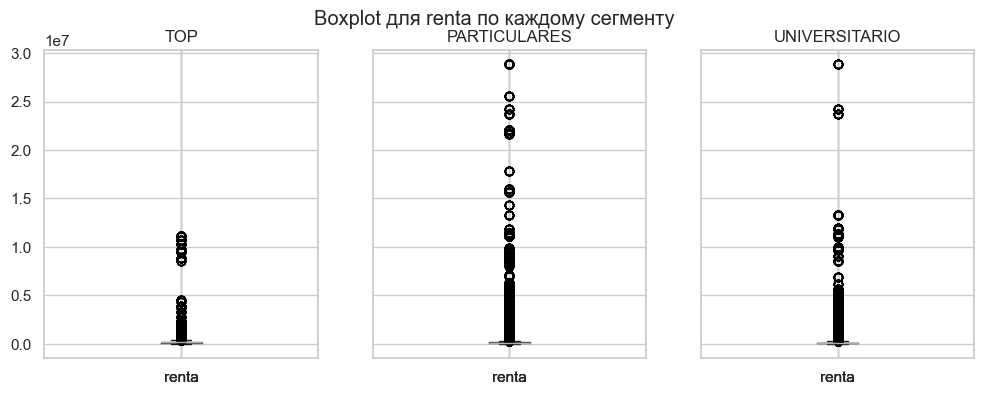

In [22]:
# Строим boxplot для renta по каждому сегменту

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12,4), sharey=True, sharex=True)

data[data['segmento'] == '01 - TOP'][['renta']].boxplot(ax=ax1).set_title('TOP')
data[data['segmento'] == '02 - PARTICULARES'][['renta']].boxplot(ax=ax2).set_title('PARTICULARES')
data[data['segmento'] == '03 - UNIVERSITARIO'][['renta']].boxplot(ax=ax3).set_title('UNIVERSITARIO')

plt.suptitle('Boxplot для renta по каждому сегменту')
plt.show()

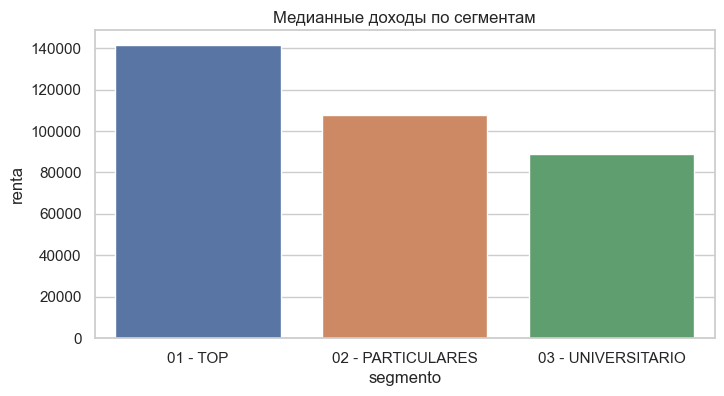

In [22]:
# Медианные доходы по сегментам
plt.figure(figsize=(8,4))
agg_by_segm = pd.DataFrame(data.groupby("segmento")["renta"].agg('median')).reset_index() 
sns.barplot(data=agg_by_segm, x='segmento', y='renta') 
plt.title(f'Медианные доходы по сегментам')
plt.show()

In [23]:
# Заполняем пропуски в renta медианными значениями в разрезе сегментов
agg_by_segm = pd.DataFrame(data.groupby(['segmento'])["renta"].agg('median'))

for segm in data['segmento'].unique():    
    selected_rows = (data.segmento == segm)
    fill_value = agg_by_segm.loc[segm, 'renta']
    data.loc[selected_rows, 'renta'] = data.loc[selected_rows, 'renta'].fillna(value=fill_value)

In [24]:
# Удаляем выбросы в renta отдельно по каждому клиентскому сегменту

threshold = 1.5
for segm in data['segmento'].unique():   
    outliers = pd.DataFrame()     
    Q1 = data[data.segmento == segm].renta.quantile(0.25)
    Q3 = data[data.segmento == segm].renta.quantile(0.75)
    IQR = Q3 - Q1
    margin = threshold * IQR
    lower = Q1 - margin
    upper = Q3 + margin
    outliers[f"is_{segm}"] = (data.segmento == segm)
    outliers["is_out"] = ~data['renta'].between(lower, upper)
    outliers = outliers[[f"is_{segm}", 'is_out']].all(axis=1)
    data = data[~outliers]

In [25]:
# Cмотрим, сколько осталось данных и уникальных клиентов после удаления строк
print(len(data))
print(data['ncodpers'].nunique())

12375258
869970


Переходим к анализу продуктовых колонок.

Добавим новые признаковые колонки с продуктами на начало месяца
и новые целевые колонки с покупкой соответствующих продуктов в течение одного месяца
(1 - клиент купил новый продукт, 0 - в противном случае)

In [26]:
# Создаем отсортированный список дат fecha_dato
dates = sorted(data['fecha_dato'].unique().tolist())

In [27]:
# Создаем словарь для получения индекса в списке дат по дате
date2idx = {d:i for i,d in enumerate(dates)}

In [28]:
# Добавляем колонку дат с лагом в 1 месяц назад
data['date_lag1m'] = data['fecha_dato'].apply(lambda d: dates[date2idx[d] - 1] if date2idx[d] > 0 else np.nan)

In [29]:
# Соединяем два одинаковых датасета, правый из которых сдвинут на 1 месяц назад
data = data.merge(data[['ncodpers', 'fecha_dato'] + prods_held], 
              how='left', left_on=['ncodpers', 'date_lag1m'], 
              right_on=['ncodpers', 'fecha_dato'],
              suffixes=(None, '_lag1m')).drop(columns=['fecha_dato_lag1m', 'date_lag1m'])

In [30]:
# Создаем список названий продуктов во владении на начало месяца
prods_held_lag1m = [f"{prod}_lag1m" for prod in prods_held]
prods_held_lag1m

['ind_ahor_fin_ult1_lag1m',
 'ind_aval_fin_ult1_lag1m',
 'ind_cco_fin_ult1_lag1m',
 'ind_cder_fin_ult1_lag1m',
 'ind_cno_fin_ult1_lag1m',
 'ind_ctju_fin_ult1_lag1m',
 'ind_ctma_fin_ult1_lag1m',
 'ind_ctop_fin_ult1_lag1m',
 'ind_ctpp_fin_ult1_lag1m',
 'ind_deco_fin_ult1_lag1m',
 'ind_deme_fin_ult1_lag1m',
 'ind_dela_fin_ult1_lag1m',
 'ind_ecue_fin_ult1_lag1m',
 'ind_fond_fin_ult1_lag1m',
 'ind_hip_fin_ult1_lag1m',
 'ind_plan_fin_ult1_lag1m',
 'ind_pres_fin_ult1_lag1m',
 'ind_reca_fin_ult1_lag1m',
 'ind_tjcr_fin_ult1_lag1m',
 'ind_valo_fin_ult1_lag1m',
 'ind_viv_fin_ult1_lag1m',
 'ind_nomina_ult1_lag1m',
 'ind_nom_pens_ult1_lag1m',
 'ind_recibo_ult1_lag1m']

In [31]:
# Заполняем пропуски в новых продуктовых колонках нулями и приводим их к типу int
data[prods_held_lag1m] = data[prods_held_lag1m].fillna(0).astype(int)

In [32]:
# Создаем список названий приобретенных продуктов
prods_added = [f"{prod}_added" for prod in prods_held]
prods_added

['ind_ahor_fin_ult1_added',
 'ind_aval_fin_ult1_added',
 'ind_cco_fin_ult1_added',
 'ind_cder_fin_ult1_added',
 'ind_cno_fin_ult1_added',
 'ind_ctju_fin_ult1_added',
 'ind_ctma_fin_ult1_added',
 'ind_ctop_fin_ult1_added',
 'ind_ctpp_fin_ult1_added',
 'ind_deco_fin_ult1_added',
 'ind_deme_fin_ult1_added',
 'ind_dela_fin_ult1_added',
 'ind_ecue_fin_ult1_added',
 'ind_fond_fin_ult1_added',
 'ind_hip_fin_ult1_added',
 'ind_plan_fin_ult1_added',
 'ind_pres_fin_ult1_added',
 'ind_reca_fin_ult1_added',
 'ind_tjcr_fin_ult1_added',
 'ind_valo_fin_ult1_added',
 'ind_viv_fin_ult1_added',
 'ind_nomina_ult1_added',
 'ind_nom_pens_ult1_added',
 'ind_recibo_ult1_added']

In [33]:
# Добавляем новые целевые колонки с приобретенными продуками
for prod in prods_held:
    data[f"{prod}_added"] = data[prod] - data[f"{prod}_lag1m"]
    data[f"{prod}_added"] = data[f"{prod}_added"].apply(lambda x: max(x, 0))

In [43]:
# Смотрим результат на примере одного произвольного клиента и продукта ind_recibo_ult1
random_ncodpers = np.random.choice(data['ncodpers'], size=1)[0]
print(random_ncodpers)

data.query(f"ncodpers == {random_ncodpers}")[['fecha_dato', 
                                              'ind_recibo_ult1', 
                                              'ind_recibo_ult1_lag1m',
                                              'ind_recibo_ult1_added']]

1025046


,fecha_dato,ind_recibo_ult1,ind_recibo_ult1_lag1m,ind_recibo_ult1_added
18459,2015-01-28,1,0,1
1098095,2015-02-28,1,1,0
1569043,2015-03-28,0,1,0
2234489,2015-04-28,0,0,0
2281609,2015-05-28,1,0,1
2947460,2015-06-28,1,1,0
3958855,2015-07-28,1,1,0
4244255,2015-08-28,1,1,0
5432238,2015-09-28,1,1,0
5877488,2015-10-28,0,1,0


Оценим динамику активности клиентов, чтобы выявить возможную сезонность в их поведении
и соответственно оставить только те данные, которые наиболее релевантны для целевой прогнозной даты 
28.06.2016.

Для этого оставим только "старых" клиентов, заключивших свой первый контракт до 01.01.2015, чтобы исключить вклад новых клиентов, и затем посчитаем общее кол-во приобретенных продуктов по месяцам

In [44]:
# Оставляем только "старых" клиентов
old_clients_data = data.query("fecha_alta < '2015-01-01'")

In [45]:
# Добавляем колонку с количеством приобретенных продуктов
old_clients_data['prods_added_num'] = old_clients_data[prods_added].sum(axis=1)

In [46]:
# Агрегируем кол-во продуктов по месяцам
agg_by_date = old_clients_data.groupby("fecha_dato")\
    .agg(tot_prods_added_num=('prods_added_num', 'sum')).reset_index()

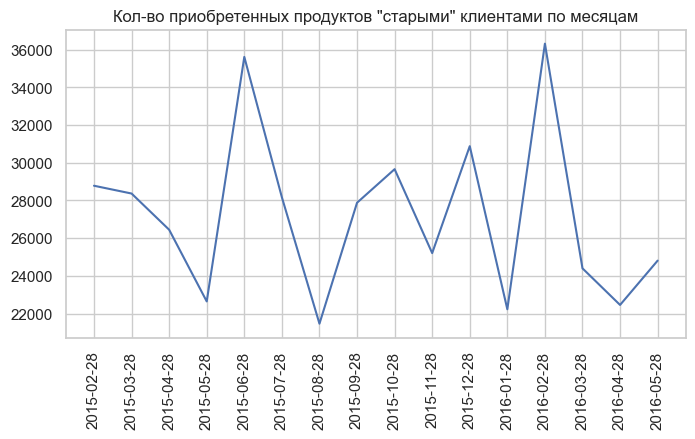

In [47]:
# Показываем кол-во приобретенных продуктов "старыми" клиентами по месяцам
plt.figure(figsize=(8,4))
plt.plot(agg_by_date.iloc[1:, :]['fecha_dato'], agg_by_date.iloc[1:, :]['tot_prods_added_num'])
plt.title('Кол-во приобретенных продуктов "старыми" клиентами по месяцам')
plt.xticks(rotation='vertical')
plt.show()

Видим, что с марта активность клиентов снижается, потом резко растет в июне, 
далее оставшуюся часть года колеблется, достигает пика в феврале и снова начинает падать.
Поэтому для получения июньского прогноза достаточно оставить данные с фераля по июнь каждого года.
Также, чтобы лучше отразить месячную сезонность, добавим месяц наблюдения вместо даты fecha_dato как новый категориальный признак

In [34]:
# Добавляем новый признак - месяц наблюдения
data['observ_month'] = pd.to_datetime(data["fecha_dato"]).dt.month

Оставляем релевантные данные и разбиваем их на train и test

In [36]:
# Train
clean_data_train = data.query(
    "fecha_dato in ('2015-02-28', '2015-03-28', '2015-04-28', '2015-05-28', '2015-06-28', \
        '2016-02-28', '2016-03-28', '2016-04-28')"
)

# Test
clean_data_test = data.query("fecha_dato == '2016-05-28'")

In [37]:
# Смотрим размер данных

print('Train:')
print(len(clean_data_train))
print(clean_data_train.ncodpers.nunique())
print()
print('Test:')
print(len(clean_data_test))
print(clean_data_test.ncodpers.nunique())

Train:
5367604
856118

Test:
849726
849726


In [12]:
# Сохраняем очищенные данные на диск
clean_data_train.to_csv('../data/clean_data_train.csv.zip', index=None)
clean_data_test.to_csv('../data/clean_data_test.csv.zip', index=None)

Отранжируем продукты по популярности. Для этого будем использовать только train-часть, чтобы можно было провести объективную валидацию рекомендаций на основе самых популярных продуктов (бейзлайн)

In [39]:
# Суммируем встречаемость каждого продукта в train и сортируем продукты по встречаемости в обратном порядке
pop_prods = clean_data_train[prods_held].sum(axis=0)
pop_prods.sort_values(inplace=True, ascending=False)

In [40]:
# Строим датафрейм популярных продуктов 
pop_prods = pd.DataFrame(pop_prods)\
    .reset_index()\
        .rename(columns={'index': 'name'})\
            .rename(columns={0: 'prods_held_num'})

In [41]:
# Добавляем колонку с индексом в списке названий продуктов (нужно для расчета метрик у бейзлайна)
pop_prods['prod_idx'] = pop_prods['name'].apply(lambda x: prod2idx[x])

In [42]:
# Добавляем колонку с английскими названиями продуктов
pop_prods['eng_name'] = pop_prods['name'].apply(lambda x: prod2eng[x])

In [43]:
# Смотрим, что получилось
pop_prods

,name,prods_held_num,prod_idx,eng_name
0,ind_cco_fin_ult1,3768670,2,Current Account
1,ind_recibo_ult1,743418,23,Direct Debit
2,ind_ctop_fin_ult1,727178,7,Particular Account
3,ind_ecue_fin_ult1,480267,12,E-account
4,ind_cno_fin_ult1,469029,4,Payroll Account
5,ind_nom_pens_ult1,343161,22,Pensions
6,ind_nomina_ult1,319716,21,Payroll
7,ind_reca_fin_ult1,285174,17,Taxes
8,ind_dela_fin_ult1,253244,11,Long-term Deposits
9,ind_tjcr_fin_ult1,252750,18,Credit Card


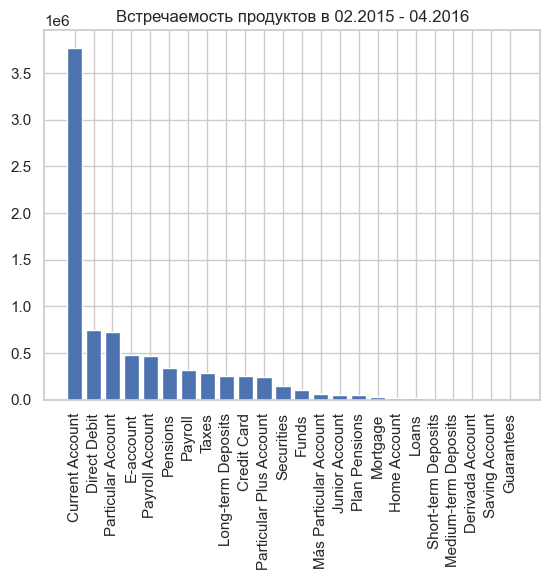

In [83]:
# Строим гистограмму встречаемости продуктов в train
plt.bar(pop_prods.eng_name, pop_prods.prods_held_num)
plt.xticks(rotation='vertical')
plt.title("Встречаемость продуктов в 02.2015 - 04.2016")
plt.show()

Видим, что некоторыми продуктами клиенты вообще не пользуются.
Поэтому для расчета MAP@k нет смысла брать k > 10

In [44]:
# Сохраняем данные о популярности продуктов в отдельном файле
pop_prods.to_parquet('../data/pop_prods.parquet')

In [57]:
# Удаляем лишние данные
del data
del old_clients_data

gc.collect()

4030

### Выводы по этапу EDA

- Проверили исходные данные на наличие дублирования, пропусков, выбросов, некорректных типов и значений:
    - Удалили признак cod_prov, т.к. он по сути дублирует nomprov; 
    - Удалили признаки ult_fec_cli_1t и conyuemp, т.к. у них почти 100% пропусков;
    - В продуктовых колонках ind_nomina_ult1 и ind_nom_pens_ult1 заполнили пропуски нулями 
    и привели их к целому типу;
    - В признаке indrel_1mes привели значения к строковому типу и одному формату;
    - Удалили строки, у которых одновременно незаполнено большое количество признаков;
    - Проверили распредение значений категориальных признаков, 
    удалили tipodom, т.к. он является константным;
    - Все бинарные категориальные признаки со значениями 1/0 привели к целому типу;
    - Строковые значения у числовых признаков и сами эти признаки привели к типу float;
    - Пропуски у числовых признаков заполнили медианами 
    (для renta в разрезе по клиентским сегментам, т.к. они отличаются по уровню доходов), 
    у категориальных - модами. 
    При этом убедились, что взятие этих статистик по всему датасету корректно, 
    т.к. если данные признаки незаполнены в одном месяце, 
    то их нет и в остальных записях соответствующих клиентов;
    - Удалили выбросы у числовых признаков (для renta отдельно по каждому клиентскому сегменту);
- Вместо fecha_alta добавили признак clientship_years как разницу между датами fecha_dato и fecha_alta 
(скольк лет человек является клиентом банка),
- Добавили колонками с продуктами на начало месяца и продуктами, которые клиенты купили в течение месяца; 
- Построили динамику покупок по месяцам для "старых" клиентов, которые начали пользоваться услугами банка
до 01.01.2015, чтобы исключить вклад новых клиентов. 
Обнаружили сезонность: с марта активность снижается, потом резко растет в июне, 
далее оставшуюся часть года колеблется, достигает пика в феврале и снова начинает падать.
Поэтому для получения июньского прогноза оставили данные с фераля по июнь каждого года;
- Чтобы лучше отразить месячную сезонность, вместо даты fecha_dato добавили месяц наблюдения;
- Проанализировали популярность продуктов (самым популярными оказались текущие счета), соответствующие данные
сохранили в файле `data/pop_prods.parquet` для формирования рекомендаций по умолчанию;
- Очищенные данные разбили на train (02.2015-06.2015, 02.2016-04.2016) и test (05.2016) 
и сохранили в файлах `data/clean_data_train.csv.zip` и `data/clean_data_test.csv.zip`

## Функции для расчета MAP@k <a id="step_0"></a>

Ниже представлены функции для расчета средней точности MAP@k по [формуле](https://www.kaggle.com/competitions/santander-product-recommendation)
$$MAP@7 = \frac{1}{|U|} \sum_{u=1}^{|U|} \frac{1}{min(m,7)} \sum_{k=1}^{min(n,7)}P(k),$$

где |U| - кол-во клиентов, n - кол-во рекомендуемых продуктов, m - кол-во добавленных продуктов.

In [4]:
def avg_prec_at_k(actual, pred, top_k=7):
    """
    Computes the average precision at k between two lists of items.
    """
    if top_k < len(pred):
        #pred = pred[pop_prods_idxs[:top_k]]
        #actual = actual[pop_prods_idxs[:top_k]]
        pred = pred[:top_k]
        actual = actual[:top_k]
    
    prec = 0.0
    tp = 0
    
    for i in range(len(pred)):
        if pred[i] == 1 and actual[i] == 1:
            tp += 1
        prec += tp / (i + 1.0)

    return 0 if tp == 0 else prec / tp


def mean_avg_prec_at_k(actual, pred, top_k=7):
    """
    Computes the mean average precision at k between two lists of lists of items.
    """
    return np.mean([avg_prec_at_k(a, p, top_k) for a, p in zip(actual, pred)])

## Расчет MAP@k для рекомендаций на основе популярности продуктов (бейзлайн) <a id="step_0"></a>

Рассчитаем MAP@7 на 28.05.2016 для бейзлайна на основе популярности продуктов, т.е. будем рекомендавать продукты из числа топ-7 популярных, причем те из них, которых нет у клиента на 28.04.2016

In [46]:
# Продукты, отсортированные по популярности в train-выборке
pop_prods.iloc[:7]

,name,prods_held_num,prod_idx,eng_name
0,ind_cco_fin_ult1,3768670,2,Current Account
1,ind_recibo_ult1,743418,23,Direct Debit
2,ind_ctop_fin_ult1,727178,7,Particular Account
3,ind_ecue_fin_ult1,480267,12,E-account
4,ind_cno_fin_ult1,469029,4,Payroll Account
5,ind_nom_pens_ult1,343161,22,Pensions
6,ind_nomina_ult1,319716,21,Payroll


In [47]:
# Фактические таргеты (продукты, купленные в мае 2016)
actual = clean_data_test[prods_added].to_numpy()
actual

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=int64)

In [48]:
# Формируем прогноз покупки продуктов для одного клиента
top_k = 7
pop_prods_added_pred_1 = np.array([0] * 24)
pop_prods_added_pred_1[pop_prods['prod_idx'][:top_k]] = 1
pop_prods_added_pred_1

array([0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1])

In [49]:
# Формируем прогноз покупки продуктов для всех клиентов
pop_prods_added_pred = np.array([pop_prods_added_pred_1] * clean_data_test.shape[0])
pop_prods_added_pred

array([[0, 0, 1, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 1, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 1, 1]])

In [50]:
# Названия колонок с предсказаниями покупок
prods_added_pred = [f"{prod}_added_pred" for prod in prods_held]
prods_added_pred

['ind_ahor_fin_ult1_added_pred',
 'ind_aval_fin_ult1_added_pred',
 'ind_cco_fin_ult1_added_pred',
 'ind_cder_fin_ult1_added_pred',
 'ind_cno_fin_ult1_added_pred',
 'ind_ctju_fin_ult1_added_pred',
 'ind_ctma_fin_ult1_added_pred',
 'ind_ctop_fin_ult1_added_pred',
 'ind_ctpp_fin_ult1_added_pred',
 'ind_deco_fin_ult1_added_pred',
 'ind_deme_fin_ult1_added_pred',
 'ind_dela_fin_ult1_added_pred',
 'ind_ecue_fin_ult1_added_pred',
 'ind_fond_fin_ult1_added_pred',
 'ind_hip_fin_ult1_added_pred',
 'ind_plan_fin_ult1_added_pred',
 'ind_pres_fin_ult1_added_pred',
 'ind_reca_fin_ult1_added_pred',
 'ind_tjcr_fin_ult1_added_pred',
 'ind_valo_fin_ult1_added_pred',
 'ind_viv_fin_ult1_added_pred',
 'ind_nomina_ult1_added_pred',
 'ind_nom_pens_ult1_added_pred',
 'ind_recibo_ult1_added_pred']

In [51]:
# Вставляем колонки с прогнозами покупок
clean_data_test[prods_added_pred] = pop_prods_added_pred

In [52]:
# Корректируем предсказания покупок с учетом продуктов, имеющихся на начало месяца
for prod in prods_held:
    clean_data_test[f"{prod}_added_pred"] = clean_data_test[f"{prod}_added_pred"] \
        - clean_data_test[f"{prod}_lag1m"]

# Приводим новые колонки к целому типу
clean_data_test[prods_added_pred] = clean_data_test[prods_added_pred].astype(int)

In [53]:
# Смотрим результат
pred = clean_data_test[prods_added_pred].to_numpy()
pred

array([[0, 0, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 1, 1]])

In [54]:
# Считаем MAP@7
mean_avg_prec_at_k(actual, pred, 7)

0.008174412356789972

## Базовая модель <a id="step_0"></a>

In [5]:
# При необходимости заново загружаем очищенные данные
clean_data_train = pd.read_csv('../data/clean_data_train.csv.zip')
clean_data_test = pd.read_csv('../data/clean_data_test.csv.zip')

In [8]:
pop_prods = pd.read_parquet('../data/pop_prods.parquet')

In [9]:
prods_held = [
    'ind_ahor_fin_ult1',
    'ind_aval_fin_ult1',
    'ind_cco_fin_ult1',
    'ind_cder_fin_ult1',
    'ind_cno_fin_ult1',
    'ind_ctju_fin_ult1',
    'ind_ctma_fin_ult1',
    'ind_ctop_fin_ult1',
    'ind_ctpp_fin_ult1',
    'ind_deco_fin_ult1',
    'ind_deme_fin_ult1',
    'ind_dela_fin_ult1',
    'ind_ecue_fin_ult1',
    'ind_fond_fin_ult1',
    'ind_hip_fin_ult1',
    'ind_plan_fin_ult1',
    'ind_pres_fin_ult1',
    'ind_reca_fin_ult1',
    'ind_tjcr_fin_ult1',
    'ind_valo_fin_ult1',
    'ind_viv_fin_ult1',
    'ind_nomina_ult1',
    'ind_nom_pens_ult1',
    'ind_recibo_ult1'
]

Группируем названия признаков и таргетов

In [10]:
# Названия продуктов во владении на начало месяца
prods_held_lag1m = [
    'ind_ahor_fin_ult1_lag1m',
    'ind_aval_fin_ult1_lag1m',
    'ind_cco_fin_ult1_lag1m',
    'ind_cder_fin_ult1_lag1m',
    'ind_cno_fin_ult1_lag1m',
    'ind_ctju_fin_ult1_lag1m',
    'ind_ctma_fin_ult1_lag1m',
    'ind_ctop_fin_ult1_lag1m',
    'ind_ctpp_fin_ult1_lag1m',
    'ind_deco_fin_ult1_lag1m',
    'ind_deme_fin_ult1_lag1m',
    'ind_dela_fin_ult1_lag1m',
    'ind_ecue_fin_ult1_lag1m',
    'ind_fond_fin_ult1_lag1m',
    'ind_hip_fin_ult1_lag1m',
    'ind_plan_fin_ult1_lag1m',
    'ind_pres_fin_ult1_lag1m',
    'ind_reca_fin_ult1_lag1m',
    'ind_tjcr_fin_ult1_lag1m',
    'ind_valo_fin_ult1_lag1m',
    'ind_viv_fin_ult1_lag1m',
    'ind_nomina_ult1_lag1m',
    'ind_nom_pens_ult1_lag1m',
    'ind_recibo_ult1_lag1m'
]

In [11]:
# Названия купленных продуктов (таргеты)
prods_added = [
    'ind_ahor_fin_ult1_added',
    'ind_aval_fin_ult1_added',
    'ind_cco_fin_ult1_added',
    'ind_cder_fin_ult1_added',
    'ind_cno_fin_ult1_added',
    'ind_ctju_fin_ult1_added',
    'ind_ctma_fin_ult1_added',
    'ind_ctop_fin_ult1_added',
    'ind_ctpp_fin_ult1_added',
    'ind_deco_fin_ult1_added',
    'ind_deme_fin_ult1_added',
    'ind_dela_fin_ult1_added',
    'ind_ecue_fin_ult1_added',
    'ind_fond_fin_ult1_added',
    'ind_hip_fin_ult1_added',
    'ind_plan_fin_ult1_added',
    'ind_pres_fin_ult1_added',
    'ind_reca_fin_ult1_added',
    'ind_tjcr_fin_ult1_added',
    'ind_valo_fin_ult1_added',
    'ind_viv_fin_ult1_added',
    'ind_nomina_ult1_added',
    'ind_nom_pens_ult1_added',
    'ind_recibo_ult1_added'
]

In [10]:
'''
clean_data_train[prods_held_lag1m] = clean_data_train[prods_held_lag1m].astype(str)
clean_data_test[prods_held_lag1m] = clean_data_test[prods_held_lag1m].astype(str)

clean_data_train['prods_held_lag1m'] = clean_data_train[prods_held_lag1m].agg(''.join, axis=1)
clean_data_test['prods_held_lag1m'] = clean_data_test[prods_held_lag1m].agg(''.join, axis=1)
'''

In [25]:
top_prods_held_lag1m = list(np.array(prods_held_lag1m)[pop_prods.prod_idx[:10]])
top_prods_added = list(np.array(prods_added)[pop_prods.prod_idx[:10]])

In [52]:
# Бинарные категориальные признаки
bin_cat_cols = [
    'sexo',
    'ind_nuevo',
    'indrel',
    'indresi',
    'indext',
    'ind_actividad_cliente'] + top_prods_held_lag1m
    
# Небинарные категориальные признаки
non_bin_cat_cols = [
    'observ_month',
    'ind_empleado',
    'pais_residencia',
    'indrel_1mes',
    'tiprel_1mes',
    'canal_entrada',
    'segmento' 
]

# Числовые признаки
num_cols = [
    'age',
    'antiguedad',
    'clientship_years',
    'renta'   
]

In [27]:
X_train = clean_data_train[bin_cat_cols + non_bin_cat_cols + num_cols]
Y_train = clean_data_train[top_prods_added]

X_test = clean_data_test[bin_cat_cols + non_bin_cat_cols + num_cols]
Y_test = clean_data_test[top_prods_added]

Создаем энкодеры для кодирования признаков

In [42]:
# Для бинарных категориальных признаков
encoder_oh = OneHotEncoder(
    categories='auto',
    handle_unknown='ignore', 
    sparse_output=False,
    drop='if_binary'
) 

# Для небинарных категориальных признаков
encoder_cb = CatBoostEncoder(random_state=RANDOM_STATE)

In [50]:
# Задаем трансформацию признаков
preprocessor = ColumnTransformer(
    [
        ('bin_cat', encoder_oh, bin_cat_cols),
        ('non_bin_cat', encoder_cb, non_bin_cat_cols),
        ('num', StandardScaler(), num_cols)
    ],
    remainder='drop',
    verbose_feature_names_out=True
)

In [34]:
# Объявляем модель cb-классификатора

loss_function = 'Logloss'
task_type = 'CPU'
depth = 6
learning_rate = 0.1
random_seed = RANDOM_STATE
iterations = 10
verbose = True

cb_clfs = []

for i in range(10):
    cb_clf = CatBoostClassifier(loss_function=loss_function,
                                task_type=task_type,
                                depth=depth,
                                learning_rate=learning_rate,
                                random_seed=random_seed,
                                iterations=iterations,
                                verbose=verbose)
    cb_clfs.append(cb_clf)

In [32]:
pipeline = Pipeline(
    [
        ('preproc', preprocessor),
        ('model', cb_clf)
    ]
)

In [56]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

ValueError: No valid specification of the columns. Only a scalar, list or slice of all integers or all strings, or boolean mask is allowed

In [39]:
X_train_transformed

array([[1.6751701688103322, 0.6248245357188451, 0.5392925450762751, ...,
        'I', 'KAT', '02 - PARTICULARES'],
       [0.018542541895793446, 0.6248245357188451, 0.5253911976151885,
        ..., 'A', 'KAT', '02 - PARTICULARES'],
       [0.32532543576885614, 0.6248245357188451, 0.5392925450762751, ...,
        'I', 'KFC', '02 - PARTICULARES'],
       ...,
       [-0.3495969307518818, -0.8974035050451539, -0.8895673832454011,
        ..., 'I', 'KFC', '02 - PARTICULARES'],
       [0.2639688569942436, -0.8974035050451539, -0.8895673832454011,
        ..., 'I', 'KFC', '02 - PARTICULARES'],
       [-0.6563798246249445, -0.8974035050451539, -0.8895673832454011,
        ..., 'A', 'KFC', '03 - UNIVERSITARIO']], dtype=object)

In [18]:
# Запускаем обучение модели
for i, cb_clf in enumerate(cb_clfs):
    X_train_transformed = 
pipeline.fit(X_train, Y_train)

CatBoostError: bad allocation

In [23]:
Y_train.unique()

array([  0,  78,  26,  15,   6, 166,   1, 107, 356, 346, 190, 219, 137,
        63,   7, 214, 340,  16,  10, 216,  20,   4,  79,  45, 149, 220,
       119, 378, 347, 408,  83, 135,  23, 178, 357, 110, 211, 402, 393,
        40,   2,  70, 225, 223, 249,  11, 170, 278, 167,  89, 215, 129,
       125, 276, 373, 427,  64, 253, 177,   3, 343, 101, 322, 396, 108,
       146, 424,  21, 350, 152, 114, 208, 404, 156,  67, 138, 452, 209,
       379, 153, 353,   5, 293, 162, 467, 161,  37, 193, 394, 150, 217,
       380, 218, 163, 228, 325,  27, 359, 413, 400, 144, 362, 307, 221,
        52, 243, 112,  55,   8,  31,  69, 122, 184, 227, 128, 485, 466,
       487,  30, 191,  24, 257, 188,  13, 345,  17, 168, 187, 174, 120,
       113,  19, 130, 103,  86, 124, 407, 123, 229, 455, 230,  72, 142,
        44,  66, 351, 453, 250,  80, 273, 139,  91, 147, 323, 326, 231,
       464, 411, 381, 461, 328, 289,  84, 234, 245, 206, 465, 198, 290,
       246, 226, 332, 384, 251,  46,  50, 305,  34, 158, 368, 18

In [17]:
Y_test_pred = pipeline.predict(X_test)
Y_test_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [18]:
# Считаем MAP@7
mean_avg_prec_at_k(Y_test, Y_test_pred, 7)

0.0